STFT分析：如果窗函数带宽长，则包络中的精细结构较少，疏松，得到窄带语谱图，有较好的频域分辨率，但时域分辨率较差；如果窗函数带宽窄，则包络中的精细结构较多，密集，得到宽带语谱图，有较好的时域分辨率，频域分辨率较差。

In [73]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

In [78]:
def STFT(waveform, sample_rate, frame_length, hop_length):
    """
    计算音频的短时傅里叶变换（STFT）。

    参数:
    waveform (numpy.ndarray): 音频信号，形状为 (n_samples,)。
    sample_rate (int): 音频采样率，单位为 Hz。
    frame_length (int): 每个 STFT 帧的长度，单位为样本数。
    hop_length (int): 帧之间的 hop 长度，单位为样本数。

    返回:
    numpy.ndarray: STFT 变换后的结果，形状为 (n_bins, n_frames)，其中 n_bins 是频率 bins 的数量，n_frames 是时间帧的数量。
    """
    pad_width = frame_length // 2
    waveform_padded = np.pad(waveform, (pad_width, pad_width), mode='reflect')

    # 计算帧数
    frame_num = 1 + int(np.floor((len(waveform_padded) - frame_length) / hop_length))

    # row 提供帧内的相对索引，col 提供每帧的起始位置索引，两者相加得到每个帧中每个样本的绝对位置
    row = np.tile(np.arange(0, frame_length), (frame_num, 1))
    col = np.tile(np.arange(0, frame_num * hop_length, hop_length), (frame_length, 1)).T
    index = row + col
    # 分帧
    waveform_frame = waveform_padded[index]
    # 窗口函数
    waveform_frame = waveform_frame * np.hamming(frame_length)
    # 快速傅里叶变换，结果为复数，
    waveform_stft = np.fft.rfft(waveform_frame)

    # 功率谱密度函数
    window = np.hamming(frame_length)
    window_norm = np.sum(window**2)
    waveform_pow = np.abs(waveform_stft) ** 2 / (window_norm * sample_rate)
    waveform_db = 10 * np.log10(waveform_pow + 1e-10)

    # 计算幅度谱
    # waveform_amplitude = np.abs(waveform_stft)
    # waveform_db = 20 * np.log10(waveform_amplitude + 1e-10)
    return waveform_db.T

In [75]:
def plot_stft_db(waveforms_stft_db, sample_rate, hop_length):
    plt.figure(figsize=(12, 8))
    librosa.display.specshow(waveforms_stft_db, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)')
    plt.ylabel('Log Frequency (Hz)')
    plt.title('STFT spectrogram (dB)')
    plt.tight_layout()
    plt.show()

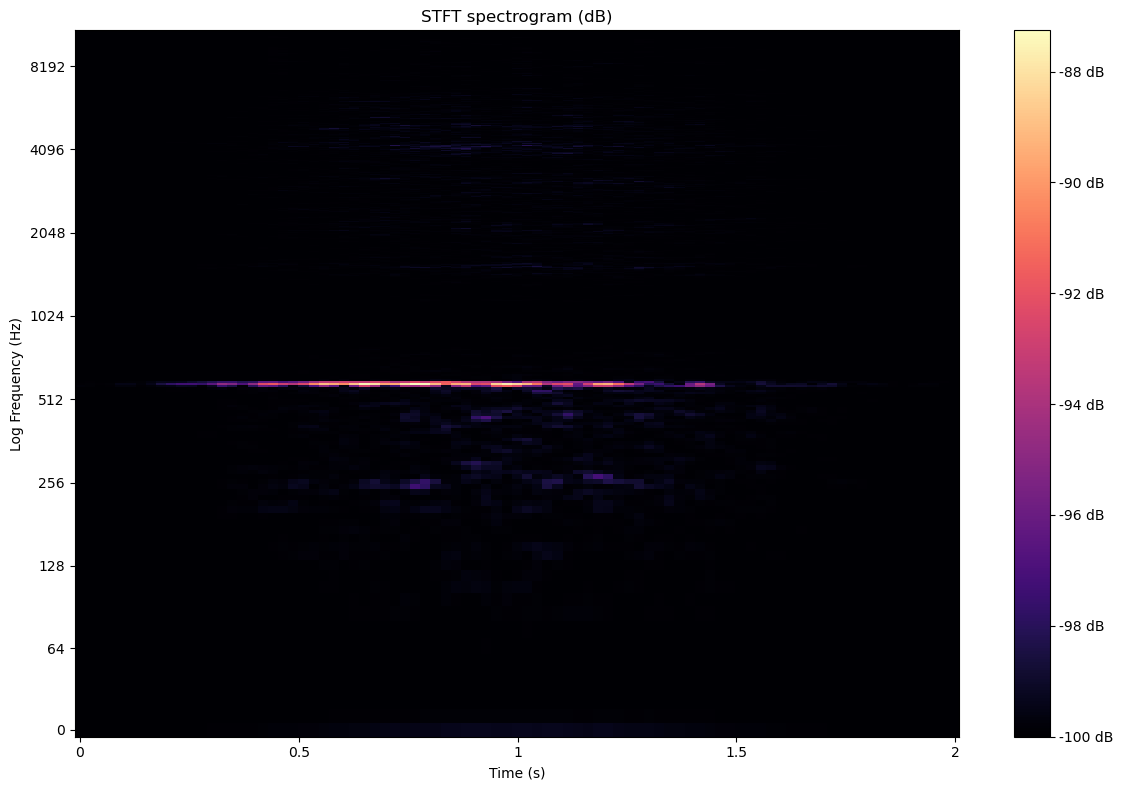

In [79]:
# 音频文件路径
audio_file = r'E:\数据集\ShipEar\data_preprocessing\3_Frame_Windows_2s_50%\6__10_07_13_marDeCangas_Entra_18.wav'

waveform, sample_rate = librosa.load(audio_file, sr=22050)

frame_length = 2048
hop_length = 512
waveforms_stft_db = STFT(waveform, sample_rate, frame_length, hop_length)
plot_stft_db(waveforms_stft_db, sample_rate, hop_length)


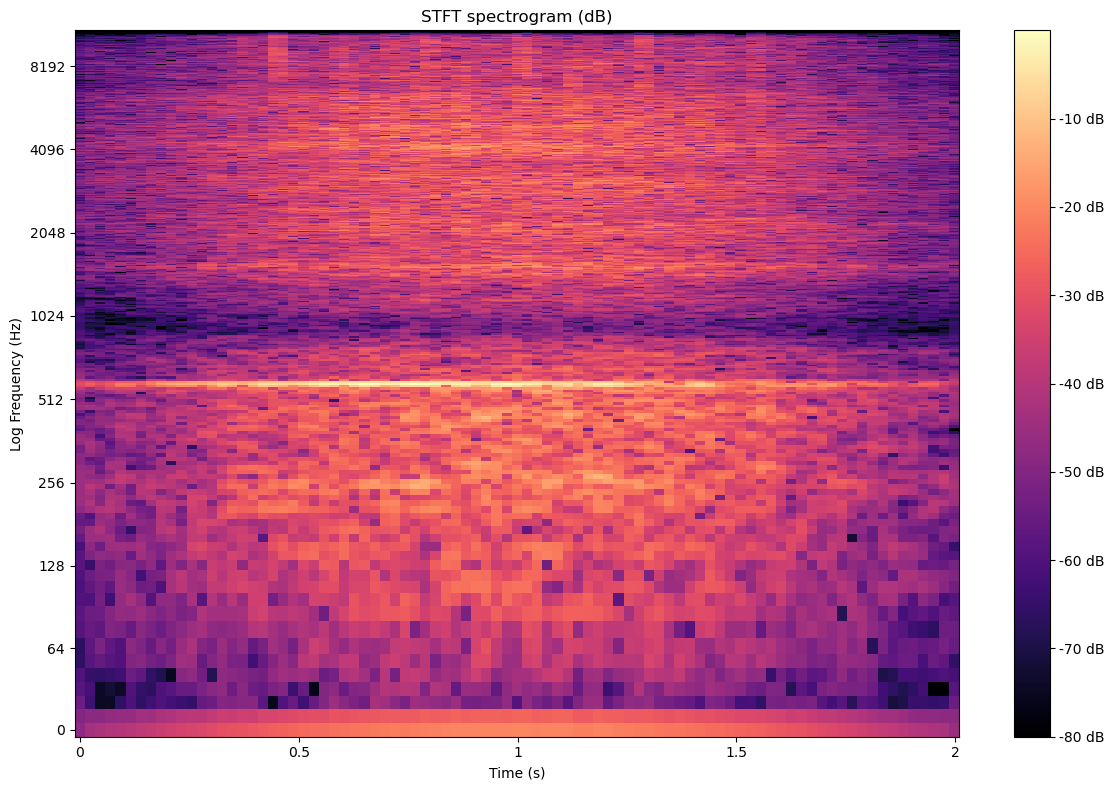

In [80]:
waveforms_stft_librosa = librosa.stft(waveform, n_fft=frame_length, hop_length=hop_length)
waveforms_stft_librosa_db = librosa.amplitude_to_db(np.abs(waveforms_stft_librosa), ref=np.max)
plot_stft_db(waveforms_stft_librosa_db, sample_rate, hop_length)